# BG/NBDモデルと機械学習モデルで予測精度を比較する
- 2013-01~2013/03までのデータをtrain, 2013/04をtestとする
- 2013/04の取引量を各モデルで予測し、そのMSEによって評価する

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('sample_transactions.csv')

In [3]:
df.index.name = 'transaction_id'
df = df.reset_index()

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.head()

,transaction_id,id,date
0,0,103121713,2013-03-06
1,1,103121713,2013-03-10
2,2,103121713,2013-03-12
3,3,103121713,2013-03-13
4,4,103121713,2013-03-15


In [6]:
df['id'].nunique()

100160

## BG/NBD

In [7]:
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

In [8]:
summary_calib_holdout = calibration_and_holdout_data(df, 'id', 'date',
                                                   calibration_period_end='2013-03-31',
                                                   observation_period_end='2013-04-30',
                                                   freq='D')
summary_calib_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
id,,,,,
103121713,12.0,23.0,25.0,15.0,30.0
103122875,35.0,86.0,88.0,12.0,30.0
103128329,12.0,78.0,85.0,0.0,30.0
103130069,41.0,81.0,89.0,0.0,30.0
103132791,10.0,78.0,86.0,0.0,30.0


In [9]:
summary_calib_holdout = summary_calib_holdout[summary_calib_holdout['frequency_cal'] != 0].copy()

In [10]:
from lifetimes import BetaGeoFitter

# x,t_x,Tに対応するcolumnを指定してBG/NBDを実行
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary_calib_holdout.frequency_cal, summary_calib_holdout.recency_cal, summary_calib_holdout.T_cal)

<lifetimes.BetaGeoFitter: fitted with 99903 subjects, a: 0.00, alpha: 11.32, b: 0.40, r: 2.40>

In [11]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.402966,0.010136,2.383100,2.422832
alpha,11.319651,0.053603,11.214588,11.424713
a,0.001547,0.000126,0.001301,0.001794
b,0.398446,0.017708,0.363739,0.433154


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

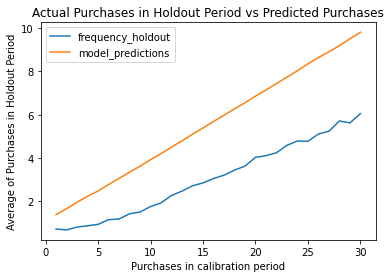

In [12]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_calib_holdout, n=30)

In [13]:
summary_calib_holdout.shape

(99903, 5)

In [14]:
summary_calib_holdout['pred'] = bgf.predict(30, summary_calib_holdout.frequency_cal, summary_calib_holdout.recency_cal, summary_calib_holdout.T_cal)

In [15]:
mean_squared_error(summary_calib_holdout['frequency_holdout'], summary_calib_holdout['pred'])

19.944267487870423

In [32]:
summary_calib_holdout.head(20)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,pred
id,,,,,,
103121713,12.0,23.0,25.0,15.0,30.0,11.885918
103122875,35.0,86.0,88.0,12.0,30.0,11.294072
103128329,12.0,78.0,85.0,0.0,30.0,4.482987
103130069,41.0,81.0,89.0,0.0,30.0,12.958186
103132791,10.0,78.0,86.0,0.0,30.0,3.820500
103133367,14.0,82.0,82.0,5.0,30.0,5.271133
103134281,14.0,83.0,84.0,2.0,30.0,5.160447
103135918,3.0,70.0,71.0,1.0,30.0,1.966786
103139881,34.0,87.0,87.0,14.0,30.0,11.104441


<AxesSubplot:xlabel='pred', ylabel='frequency_holdout'>

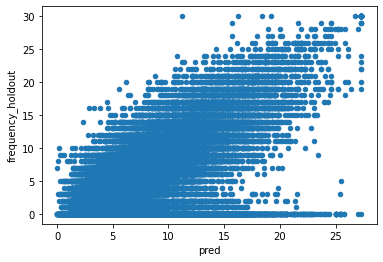

In [16]:
summary_calib_holdout[['frequency_holdout', 'pred']].plot(kind='scatter', x='pred', y='frequency_holdout')

## ML
- BG/NBDモデルと条件を揃えるのが難しい
- とりあえず1-2月のRFを使って3月のFを予測するモデルを作って、2-3月のデータから4月のFを予測する
- MLは2ヶ月分しかデータを使ってないのでBG/NBDよりも不利

In [17]:
train = calibration_and_holdout_data(df, 'id', 'date',
                                                   calibration_period_end='2013-02-28',
                                                   observation_period_end='2013-03-31',
                                                   freq='D')

In [18]:
test = calibration_and_holdout_data(df[df['date']>='2013-02-01'], 'id', 'date',
                                                   calibration_period_end='2013-03-31',
                                                   observation_period_end='2013-04-30',
                                                   freq='D')

In [19]:
train = train[train['frequency_cal'] != 0].copy()
test = test[test['frequency_cal'] != 0].copy()

In [20]:
train['remain_day'] = train['T_cal'] - train['recency_cal']
test['remain_day'] = test['T_cal'] - test['recency_cal']

In [21]:
from sklearn.linear_model import Ridge

In [22]:
model = Ridge()

In [23]:
model.fit(train[['frequency_cal','remain_day']], train['frequency_holdout'])

Ridge()

In [24]:
model.coef_

array([0.43060294, 0.01296463])

In [25]:
test['pred'] = model.predict(test[['frequency_cal','remain_day']])

In [27]:
mean_squared_error(test['frequency_holdout'], test['pred'])

17.876815737790533

<AxesSubplot:xlabel='pred', ylabel='frequency_holdout'>

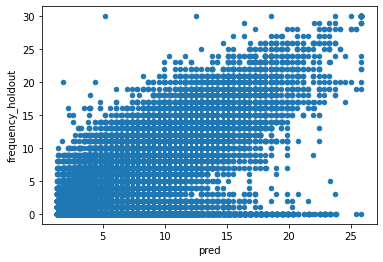

In [28]:
test[['frequency_holdout', 'pred']].plot(kind='scatter', x='pred', y='frequency_holdout')

In [31]:
test.head(20)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,remain_day,pred
id,,,,,,,
103121713,12.0,23.0,25.0,15.0,30.0,2.0,6.078488
103122875,20.0,55.0,57.0,12.0,30.0,2.0,9.523311
103128329,7.0,46.0,53.0,0.0,30.0,7.0,3.990296
103130069,25.0,50.0,58.0,0.0,30.0,8.0,11.754114
103132791,7.0,41.0,49.0,0.0,30.0,8.0,4.003261
103133367,8.0,42.0,42.0,5.0,30.0,0.0,4.330147
103134281,11.0,56.0,57.0,2.0,30.0,1.0,5.634920
103135918,1.0,56.0,57.0,1.0,30.0,1.0,1.328891
103139881,25.0,58.0,58.0,14.0,30.0,0.0,11.650397


# まとめ
- MSEの結果としては利用しているデータの少ないML(しかもリッジ回帰)が勝ってしまった